# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import random
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.datasets import load_svmlight_file
import time 
from tqdm import tqdm
np.random.seed(4)

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

Из семинара мы знаем, что теоретический шаг для $\text{Rand}\,m\%$ выглядит следующим образом: 
$$
\gamma_k = \dfrac{1}{4L(1 + \frac{2\cdot100}{nm})}
$$
Его и будем использовать в каждом случае. 

На каждом шаге для метода сжатия $\text{Rand}\,m\%$ число переданной информации равно $\dfrac{ndm}{100}$.

In [3]:
def generator(d, mu, L):
    D = np.diag(np.repeat([L, mu], [d / 2 + 1, d / 2 - 1]))
    Sample = (L - mu) * np.random.rand(d, d) + mu
    Q, _ = np.linalg.qr(Sample)
    A = Q.T @ D @ Q
    return A

In [4]:
d = 100
mu = 1
L = 1000
n = 10
A_i = []
b_i = []
for i in range(n):
    np.random.seed(4 + i)
    A_i.append(generator(d, mu, L))
    b_i.append(np.random.randn(d))
np.random.seed(4)

In [5]:
def nabla_f_j(x, j):
    return A_i[j] @ x - b_i[j]

def nabla_f(x):
    return 1 / n * sum(nabla_f_j(x, j) for j in range(n))

Оператор сжатия $\text{Rand k}\%$:

In [6]:
def gamma_rand_m(m, c):
    return 1 / (4 * L * (1 + 200 / m * n))

def Q_rand(grad_f, m):
    sample = random.sample(range(d), d * m // 100)
    Q_nabla_f = np.zeros(d)
    for i in sample:
        Q_nabla_f[i] = grad_f[i]
    return Q_nabla_f

Реализуем симуляцию распределенного градиентного спуска:

In [7]:
def PGD(grad_f_j, grad_f, compressor, m, gamma, c = 1, eps = 10**(-2), max_iter = 5 * 10**5):
    error = []
    x_cur = np.random.randn(d)
    
    while(True):
        grad_f_cur = sum(compressor(grad_f_j(x_cur, j), m) for j in range(n))
        x_new = x_cur - gamma(m, c) * grad_f_cur
        
        error.append(np.linalg.norm(grad_f(x_cur))**2)
        
        if np.linalg.norm(grad_f(x_cur))**2 < eps or len(error) > max_iter // m:
            break
        x_cur = x_new
        
    return x_new, error

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:12<00:00, 63.05s/it]


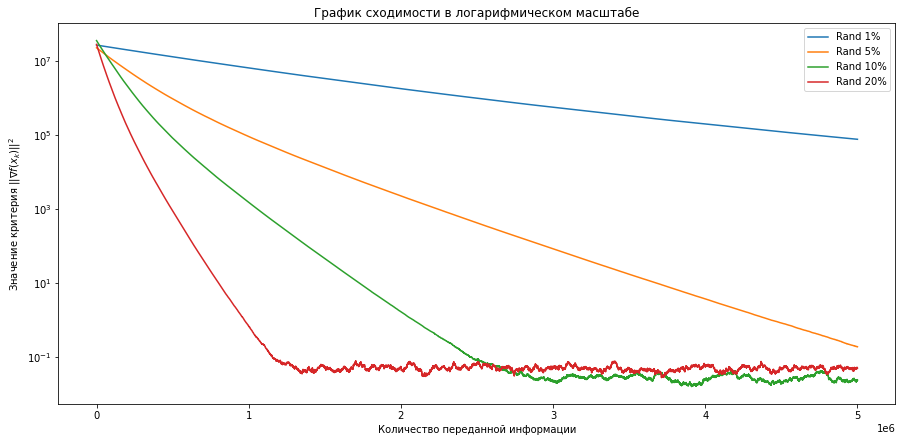

In [7]:
fig = plt.figure(figsize = (15, 7))

for m in tqdm([1, 5, 10, 20]):
    info = m * d * n / 100
    _, error = PGD(nabla_f_j, nabla_f, Q_rand, m, gamma_rand_m)
    x = np.array(range(len(error))) * info 
    plt.plot(x, error, label = f'Rand {m}%')
    
plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Количество переданной информации")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Как видно из графиков, все алгоритмы сходятся, но начинают осциллировать около значения критерия $||\nabla f||^2\approx 10^{-1}$.

### Пункт (б)

Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

Реализуем оператор сжатия $\text{Top k}\%$:

In [8]:
from torch import topk, tensor

In [9]:
def Q_top(grad_f, k):
    sample = topk(tensor(np.abs(grad_f)), k)
    Q_nabla_f = np.zeros(d)
    for i in range(k):
        Q_nabla_f[sample[1][i].numpy()] = grad_f[sample[1][i].numpy()]
    
    return Q_nabla_f

def gamma_top_k(k, c):
    return c / (4 * L * (1 + 200 / k * n))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.99s/it]


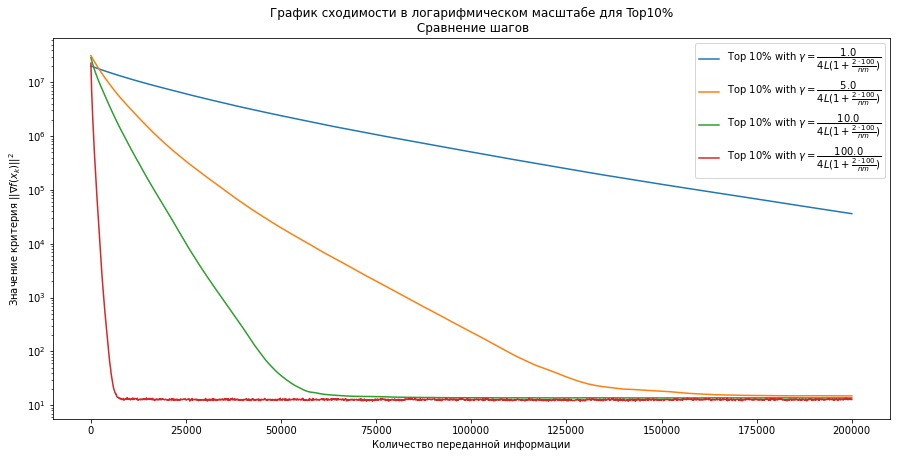

In [10]:
fig = plt.figure(figsize = (15, 7))
k = 10
for c in tqdm([1., 5., 10., 100.]):
    info = k * d * n / 100
    _, error = PGD(nabla_f_j, nabla_f, Q_top, k, gamma_top_k, c = c, max_iter = 0.2 * 10**5)
    x = np.array(range(len(error))) * info 
    plt.plot(x, error, label = 'Top 10%' + r' with $\gamma = \dfrac{%.1f}{4L(1 + \frac{2\cdot100}{nm})}$' %c)
    
plt.title("График сходимости в логарифмическом масштабе для Top10%\n Сравнение шагов")
plt.xlabel("Количество переданной информации")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Теперь для распределенного градиентного спуска с сжатием $\text{Top 10}\%$ будем использовать 
$\gamma_k = \dfrac{100}{4L(1 + \frac{2\cdot100}{nm})}$.

In [10]:
def EF(grad_f_j, grad_f, compressor, m, gamma, c = 1, eps = 10**(-2), max_iter = 5 * 10**5):
    e = [0] * n
    error = []
    x_cur = np.random.randn(d)
    
    while(True):
        estimator = np.zeros(d)
        for j in range(n):
            delta = compressor(e[j] + gamma(m, c) * grad_f_j(x_cur, j), m)
            e[j] += gamma(m, c) * grad_f_j(x_cur, j) - delta
            estimator += delta
        
        x_new = x_cur - 1 / n * estimator
        
        error.append(np.linalg.norm(grad_f(x_cur))**2)
        
        if np.linalg.norm(grad_f(x_cur))**2 < eps or len(error) > max_iter // m:
            break
        x_cur = x_new
    
    return x_cur, error

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:49<00:00, 57.43s/it]


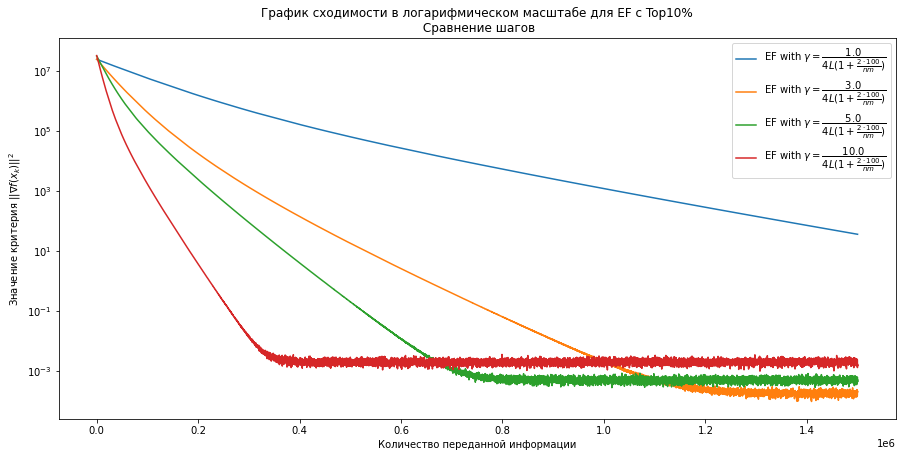

In [12]:
fig = plt.figure(figsize = (15, 7))
k = 10
for c in tqdm([1., 3., 5., 10.]):
    info = k * d * n / 100
    _, error = EF(nabla_f_j, nabla_f, Q_top, k, gamma_top_k, c = c, eps = 10**(-6), max_iter = 1.5 * 10**5)
    x = np.array(range(len(error))) * info 
    plt.plot(x, error, label = 'EF' + r' with $\gamma = \dfrac{%.1f}{4L(1 + \frac{2\cdot100}{nm})}$' %c)
    
plt.title("График сходимости в логарифмическом масштабе для EF с Top10%\n Сравнение шагов")
plt.xlabel("Количество переданной информации")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Для метода компенсации ошибок с $\text{Top k}\%$ теперь будем использовать $\gamma_k = \dfrac{3}{4L(1 + \frac{2\cdot100}{nm})}$, чтобы сходится не слошком долго, но достаточно точно.

Обычный распределенный градиентный спуск сходится быстрее чем EF, но точность сходимости отличается аж на 4 порядка, это, почти наверное, значит, что выбирать надо компенсацию ошибок.

### Правка 
Как таковое сравнение написано выше; чтобы было нагляднее, построим на одном графике EF и PGD с $\text{Top 10}\%$ и лучшими шагами:

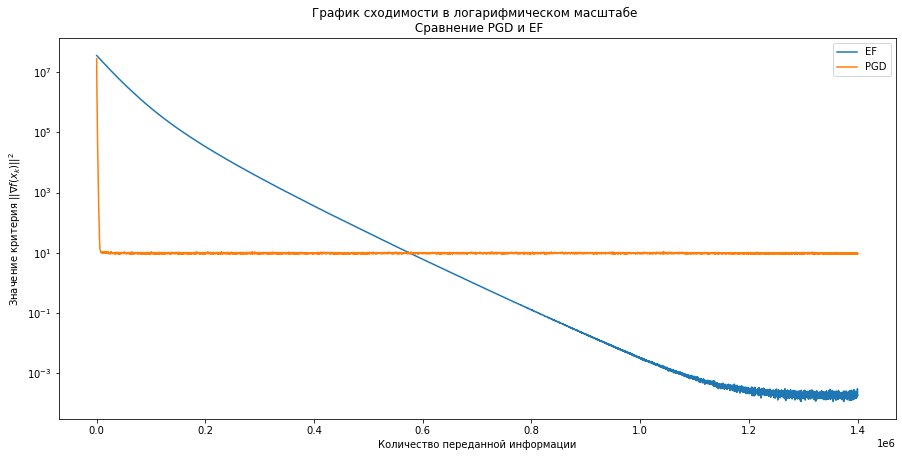

In [12]:
fig = plt.figure(figsize = (15, 7))
k = 10
info = k * d * n / 100

_, error_EF = EF(nabla_f_j, nabla_f, Q_top, k, gamma_top_k, c = 3, eps = 10**(-6), max_iter = 1.4 * 10**5)
x_EF = np.array(range(len(error_EF))) * info 
plt.plot(x_EF, error_EF, label = 'EF')

_, error = PGD(nabla_f_j, nabla_f, Q_top, k, gamma_top_k, c = 100., max_iter = 1.4 * 10**5)
x = np.array(range(len(error))) * info 
plt.plot(x, error, label = 'PGD')

plt.title("График сходимости в логарифмическом масштабе \n Сравнение PGD и EF")
plt.xlabel("Количество переданной информации")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Тут уже очевидно, зачем нужен EF: точность решения повышается значительно. 

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [13]:
dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = pd.DataFrame(y)
y = np.array(y.replace(2, 0)).reshape(8124,)

In [14]:
A = pd.DataFrame(X)
A['target'] = y
A = A.sample(frac = 1)
A_i = []
b_i = []
for j in range(n):
    promA = A[j * (A.shape[0] // n) : (j + 1) * (A.shape[0] // n)].drop(['target'], axis = 1).values
    promb = A['target'][j * (A.shape[0] // n) : (j + 1) * (A.shape[0] // n)].values
    A_i.append((2 / X.shape[0]) * promA.T @ promA)
    b_i.append((2 / X.shape[0]) * promA.T @ promb)
d = X.shape[1]
L = max(np.real(np.linalg.eigvals((2 / (X.shape[0])) * (X.T @ X))))
mu = 0
print('L = %f' % L)
print('mu = %i' % mu)

L = 20.689714
mu = 0


__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

Первые два метода уже реализованны, их возьмем из первой задачи с лучшими константами шага. Для DIANA шаг будем подбирать в таком же виде: 
$$
\gamma_k = \dfrac{c}{4L(1 + \frac{2\cdot100}{nm})}
$$
Параметр альфа, нужный в реализации, взят из прикрепленной статьи: 
$$
\alpha = \dfrac{k}{k + 100},
$$
для $\text{Top k}\%$ и $\text{Rand k}\%$ соответственно.

In [15]:
def DIANA(grad_f_j, grad_f, compressor, m, gamma, c = 1, eps = 10**(-2), max_iter = 5 * 10**5):
    
    h = [0] * n
    alpha = m / (m + 100)
    error = []
    x_cur = np.random.sample(d)
    
    while(True):
        estimator = np.zeros(d)
        
        for j in range(n):
            delta_j = compressor(grad_f_j(x_cur, j) - h[j], m)
            h[j] += alpha * delta_j
            estimator += h[j] + delta_j
            
        x_new = x_cur - gamma(m, c) * (1 / n) * estimator
        
        error.append(np.linalg.norm(grad_f(x_cur))**2)
        
        if np.linalg.norm(grad_f(x_cur))**2 < eps or len(error) > max_iter // m:
            break
        x_cur = x_new
    
    return x_cur, error

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:08<00:00, 17.17s/it]


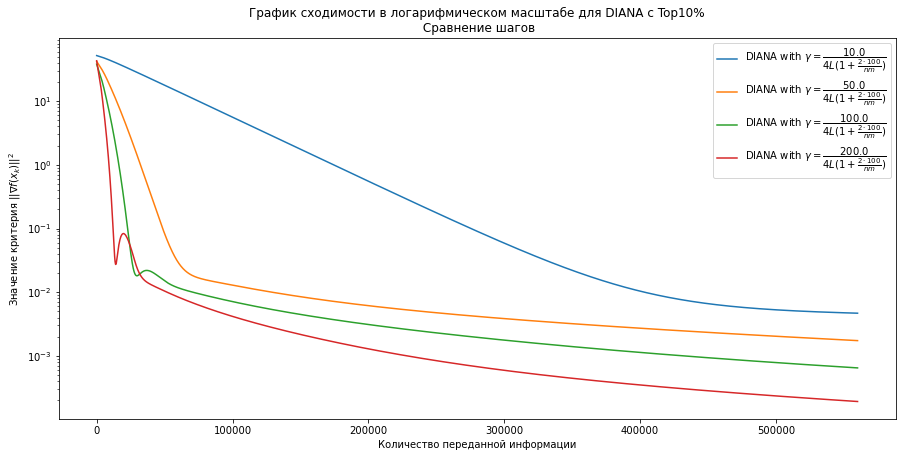

In [16]:
fig = plt.figure(figsize = (15, 7))
k = 10
for c in tqdm([10., 50., 100., 200.]):
    info = k * d * n / 100
    _, error = DIANA(nabla_f_j, nabla_f, Q_top, k, gamma_top_k, c = c, eps = 10**(-6), max_iter = 5 * 10**4)
    x = np.array(range(len(error))) * info 
    plt.plot(x, error, label = 'DIANA' + r' with $\gamma = \dfrac{%.1f}{4L(1 + \frac{2\cdot100}{nm})}$' %c)
    
plt.title("График сходимости в логарифмическом масштабе для DIANA с Top10%\n Сравнение шагов")
plt.xlabel("Количество переданной информации")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Как видно из графиков, сходимость получилась шикарная, однако стоит заметить, что оптимальный шаг сильно отличается от теоретического: на два порядка. Далее будем пользоваться шагом $\gamma_k = \dfrac{200}{4L(1 + \frac{200}{nm})}$.

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

2it [05:17, 158.74s/it]


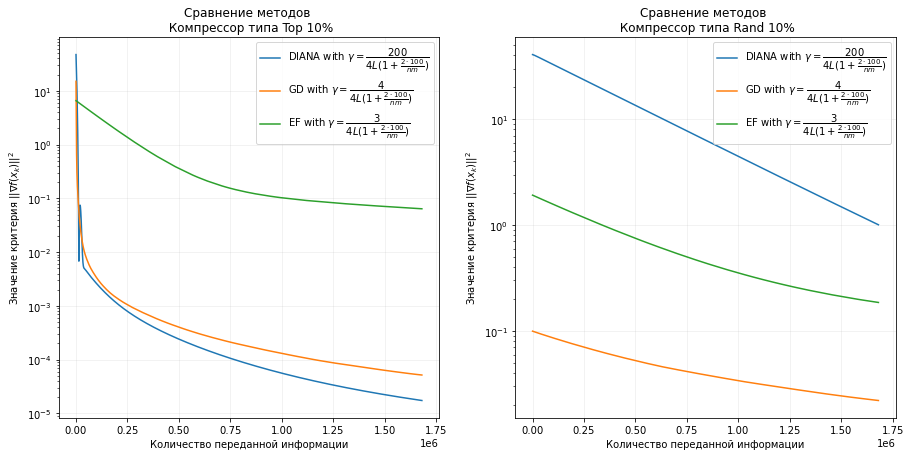

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
k = 10
info = k * d * n / 100
for i, compressor in tqdm(enumerate([gamma_top_k, gamma_rand_m])):
    _, error_D_T = DIANA(nabla_f_j, nabla_f, Q_top, k, compressor, c = 200., eps = 10**(-6), max_iter = 1.5 * 10**5)
    x_D_T = np.array(range(len(error_D_T))) * info 
    ax[i].plot(x_D_T, error_D_T, label = 'DIANA' + r' with $\gamma = \dfrac{200}{4L(1 + \frac{2\cdot100}{nm})}$')

    _, error_GD_T = PGD(nabla_f_j, nabla_f, Q_top, k, compressor, c = 100., eps = 10**(-6), max_iter = 1.5 * 10**5)
    x_GD_T = np.array(range(len(error_GD_T))) * info 
    ax[i].plot(x_GD_T, error_GD_T, label = 'GD' + r' with $\gamma = \dfrac{4}{4L(1 + \frac{2\cdot100}{nm})}$')

    _, error_EF_T = EF(nabla_f_j, nabla_f, Q_top, k, compressor, c = 3., eps = 10**(-6), max_iter = 1.5 * 10**5)
    x_EF_T = np.array(range(len(error_EF_T))) * info 
    ax[i].plot(x_EF_T, error_EF_T, label = 'EF' + r' with $\gamma = \dfrac{3}{4L(1 + \frac{2\cdot100}{nm})}$')
    
    ax[i].set_ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
    ax[i].set_xlabel('Количество переданной информации')
    ax[i].grid(alpha = 0.2)
    ax[i].legend()
    ax[i].set_yscale('log')
    
ax[0].set_title("Сравнение методов \n Компрессор типа Top 10%")
ax[1].set_title("Сравнение методов \n Компрессор типа Rand 10%")
plt.show()

Имеем:
1) Компрессор $\text{Top k}\%$ показывает значительно более хорошие результаты, нежели чем $\text{Rand k}\%$, причем для всех методов.

2) Лучше всех в целом сошлась DIANA с подогнанным шагом, причем сошлась до хорошей точности за вменяемое количество итераций.

3) Для $\text{Rand k}\%$ заметно лучше сходится обычный распараллеленный GD.

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [18]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [19]:
#ответ